In [18]:
import json
import math
import random
from collections import defaultdict
from plot import Plot

## Multi-armed Bandit

#### Implementation

In [2]:
class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        pass

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()

#### Simulation

To demonstrate the effect of different multi-armed bandit strategies and their parameters, we use the following simple simulation. The simulation is an implementation of a simple multi-armed bandit problem with five actions, ```actions = [0, 1, 2, 3, 4]```.  Each action has a probability associated with it: ```probabilities = [0.1, 0.3, 0.7, 0.2, 0.1]```. The simulation runs  2000 episodes of a bandit problem, with each episode being 1000 steps long. At each step, the agent must chose an action. For the action `a` it chooses,  it receives a reward of 5 with a probability `probability[a]`.  With a probability of ```1 - probability[a]``` it receives a reward of 0. At the beginning of each episode, the bandit strategies are reset.

The simulation returns a list of lists, representing the reward received at each step of each episode. The aim for the bandit is to maximise the expected rewards over each episode.

In [3]:
class QFunction:

    """ Update the Q-value of (state, action) by delta """

    def update(self, state, action, delta):
        pass

    """ Get a Q value for a given state-action pair """

    def get_q_value(self, state, action):
        pass

    """ Save a policy to a specified filename """
    def save_policy(self, filename):
        pass

    """ Load a policy from a specified filename """
    def load_policy(self, filename):
        pass

    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q

    """ Return the maximum Q-value in this Q-function """
    def get_max_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return max_q

    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        arg_max_q = None
        max_q = float("-inf")
        for action in actions:
            value = self.get_q_value(state, action)
            if max_q < value:
                arg_max_q = action
                max_q = value
        return (arg_max_q, max_q)


class QTable(QFunction):
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def save(self, filename):
        with open(filename, "w") as file:
            serialised = {str(key): value for key, value in self.qtable.items()}
            json.dump(serialised, file)

    def load(self, filename, default=0.0):
        with open(filename, "r") as file:
            serialised = json.load(file)
            self.qtable = defaultdict(
                lambda: default,
                {tuple(eval(key)): value for key, value in serialised.items()},
            )

In [11]:

""" Run a bandit algorithm for a number of episodes, with each episode
being a set length.
"""

def run_bandit(bandit, episodes=200, episode_length=500, drift=True):

    # The actions available
    actions = [0, 1, 2, 3, 4]

    # A dummy state
    state = 1

    rewards = []
    for _ in range(0, episodes):
        bandit.reset()

        # The probability of receiving a payoff of 1 for each action
        probabilities = [0.1, 0.3, 0.7, 0.2, 0.1]

        # The number of times each arm has been selected
        times_selected = defaultdict(lambda: 0)
        qtable = QTable()

        episode_rewards = []
        for step in range(0, episode_length):

            # Halfway through the episode, change the probabilities.
            if drift and step == episode_length / 2:
                probabilities = [0.5, 0.2, 0.0, 0.3, 0.3]

            # Select an action using the bandit
            action = bandit.select(state, actions, qtable)

            # Get the reward for that action
            reward = 0
            if random.random() < probabilities[action]:
                reward = 5
                
            episode_rewards += [reward]

            times_selected[action] = times_selected[action] + 1
            qtable.update(
                state,
                action,
                (reward / times_selected[action])
                - (qtable.get_q_value(state, action) / times_selected[action])
            )

        rewards += [episode_rewards]

    return rewards

## Strategies

#### $\epsilon$-greedy strategy

In [12]:
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # Select a random action with epsilon probability
        if random.random() < self.epsilon:
            return random.choice(actions)
        arg_max_q = qfunction.get_argmax_q(state, actions)
        return arg_max_q

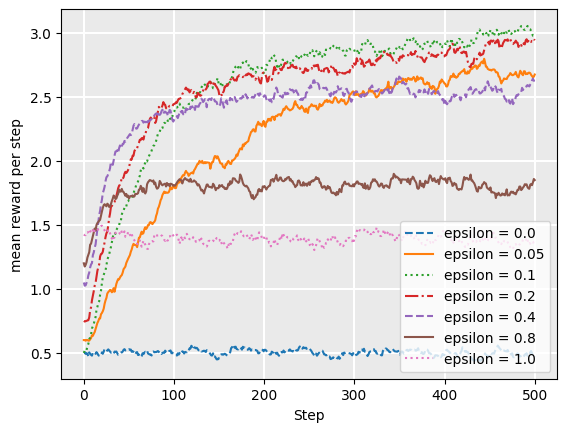

In [14]:
def plot_epsilon_greedy(drift=False):
    epsilon000 = run_bandit(EpsilonGreedy(epsilon=0.00), drift=drift)
    epsilon005 = run_bandit(EpsilonGreedy(epsilon=0.05), drift=drift)
    epsilon01 = run_bandit(EpsilonGreedy(epsilon=0.1), drift=drift)
    epsilon02 = run_bandit(EpsilonGreedy(epsilon=0.2), drift=drift)
    epsilon04 = run_bandit(EpsilonGreedy(epsilon=0.4), drift=drift)
    epsilon08 = run_bandit(EpsilonGreedy(epsilon=0.8), drift=drift)
    epsilon10 = run_bandit(EpsilonGreedy(epsilon=1.0), drift=drift)

    Plot.plot_rewards(
        [
            "epsilon = 0.0",
            "epsilon = 0.05",
            "epsilon = 0.1",
            "epsilon = 0.2",
            "epsilon = 0.4",
            "epsilon = 0.8",
            "epsilon = 1.0",
        ],
        [epsilon000, epsilon005, epsilon01, epsilon02, epsilon04, epsilon08, epsilon10],
    )


plot_epsilon_greedy()

#### $\epsilon$-decreasing strategy

In [16]:
class EpsilonDecreasing(MultiArmedBandit):
    def __init__(self, epsilon=1.0, alpha=0.999, lower_bound=0.1):
        self.epsilon_greedy_bandit = EpsilonGreedy(epsilon)
        self.initial_epsilon = epsilon
        self.alpha = alpha
        self.lower_bound = lower_bound

    def reset(self):
        self.epsilon_greedy_bandit = EpsilonGreedy(self.initial_epsilon)

    def select(self, state, actions, qfunction):
        result = self.epsilon_greedy_bandit.select(state, actions, qfunction)
        self.epsilon_greedy_bandit.epsilon = max(
            self.epsilon_greedy_bandit.epsilon * self.alpha, self.lower_bound
        )
        return result

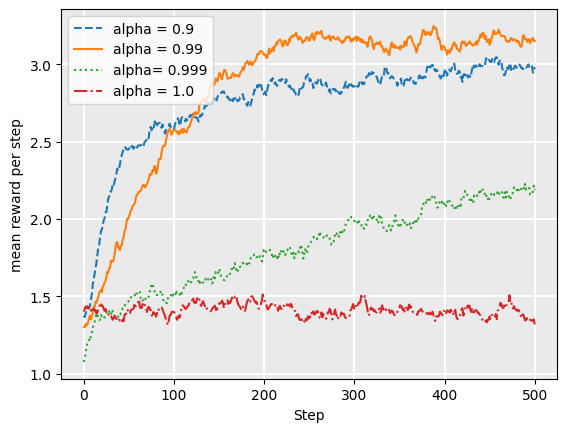

In [17]:
def plot_epsilon_decreasing(drift=False):
    alpha09 = run_bandit(EpsilonDecreasing(alpha=0.9), drift=drift)
    alpha099 = run_bandit(EpsilonDecreasing(alpha=0.99), drift=drift)
    alpha0999 = run_bandit(EpsilonDecreasing(alpha=0.999), drift=drift)
    alpha1 = run_bandit(EpsilonDecreasing(alpha=1.0), drift=drift)

    Plot.plot_rewards(
        ["alpha = 0.9", "alpha = 0.99", "alpha= 0.999", "alpha = 1.0"],
        [alpha09, alpha099, alpha0999, alpha1],
    )


plot_epsilon_decreasing()

#### Softmax strategy

In [19]:
class Softmax(MultiArmedBandit):
    def __init__(self, tau=1.0):
        self.tau = tau

    def reset(self):
        pass

    def select(self, state, actions, qfunction):

        # calculate the denominator for the softmax strategy
        total = 0.0
        for action in actions:
            total += math.exp(qfunction.get_q_value(state, action) / self.tau)

        rand = random.random()
        cumulative_probability = 0.0
        result = None
        for action in actions:
            probability = (
                math.exp(qfunction.get_q_value(state, action) / self.tau) / total
            )
            if cumulative_probability <= rand <= cumulative_probability + probability:
                result = action
            cumulative_probability += probability

        return result

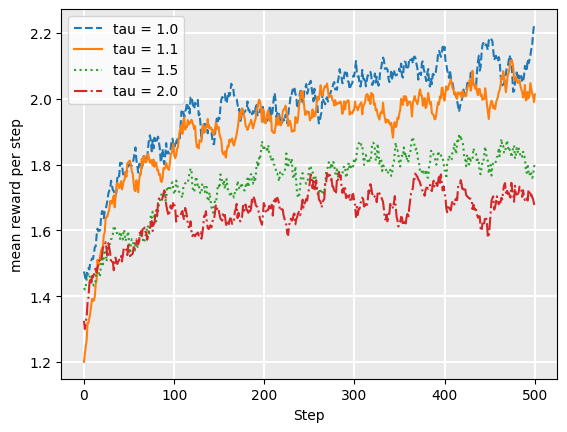

In [20]:
def plot_softmax(drift=False):
    tau10 = run_bandit(Softmax(tau=1.0), drift=drift)
    tau11 = run_bandit(Softmax(tau=1.1), drift=drift)
    tau15 = run_bandit(Softmax(tau=1.5), drift=drift)
    tau20 = run_bandit(Softmax(tau=2.0), drift=drift)

    Plot.plot_rewards(
        ["tau = 1.0", "tau = 1.1", "tau = 1.5", "tau = 2.0"],
        [tau10, tau11, tau15, tau20],
    )


plot_softmax(drift=False)

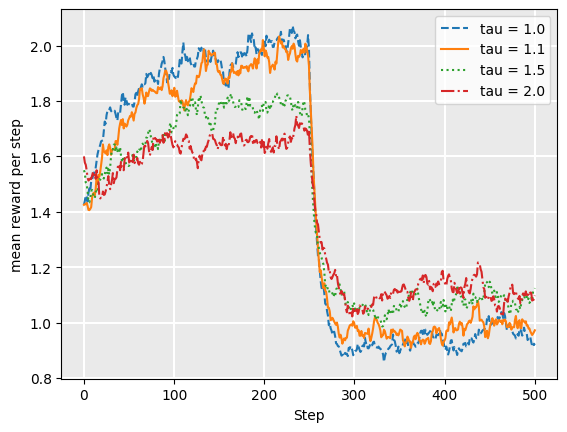

In [21]:
plot_softmax(drift=True)

#### Upper Confidence Bounds (UCB1)

In [25]:
class UpperConfidenceBounds(MultiArmedBandit):
    def __init__(self):
        self.total = 0
        # number of times each action has been chosen
        self.times_selected = {}

    def select(self, state, actions, qfunction):

        # First execute each action on time
        for action in actions:
            if action not in self.times_selected.keys():
                self.times_selected[action] = 1
                self.total += 1
                return action
            
        max_action = []
        max_value = float("-inf")
        for action in actions:
            value = qfunction.get_q_value(state, action) + math.sqrt(
                (2 * math.log(self.total)) / self.times_selected[action]
            )
            if value > max_value:
                max_actions = [action]
                max_value = value
            elif value == max_value:
                max_actions += [action]

        # if there are multiple actions with the highest value
        # choose one randomly
        result = random.choice(max_actions)
        self.times_selected[result] = self.times_selected[result] + 1
        self.total += 1
        return result

#### Comparison

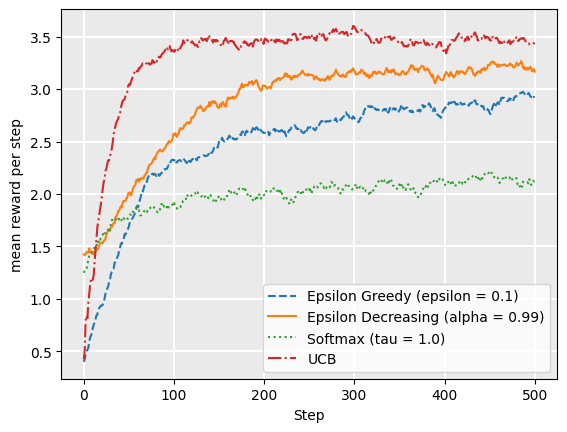

In [28]:
def plot_comparison(drift=False):
    epsilon_greedy = run_bandit(EpsilonGreedy(epsilon=0.1), drift=drift)
    epsilon_decreasing = run_bandit(EpsilonDecreasing(alpha=0.99), drift=drift)
    softmax = run_bandit(Softmax(tau=1.0), drift=drift)
    ucb = run_bandit(UpperConfidenceBounds(), drift=drift)

    Plot.plot_rewards(
        [
            "Epsilon Greedy (epsilon = 0.1)",
            "Epsilon Decreasing (alpha = 0.99)",
            "Softmax (tau = 1.0)",
            "UCB",
        ],
        [epsilon_greedy, epsilon_decreasing, softmax, ucb],
    )


plot_comparison(drift=False)

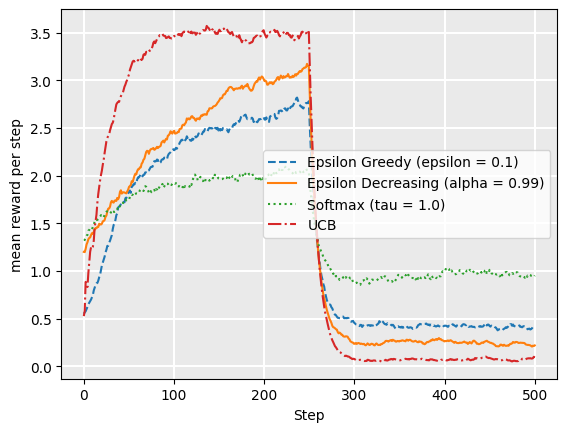

In [29]:
plot_comparison(drift=True)

From this comparison, we can see that softmax, even with tau = 1.0, adapts more quickly than other strategies. UCB1 recovers quite quickly too, soon out-performing softmax. For UCB1, the Q-values for the actions that were previously good are no longer good. This encourages exploration to other actions. But also, the actions that had poor Q-values previously but are now good actions would not have been visited as much previously, which also encourages exploration. 

Epsilon decreasing never recovers because by the time the probabilities change, epsilon is low and it is committed to those values. For that reason, the $\epsilon$-decreasing strategy is good only for static problems.

While in this particular case, UCB1 has a higher average reward over the entire episode, this may not be the case if the underlying probability distributions change or drift regularly. In those cases, softmax may be a better choice.

## Bayesian Bandit


In [ ]:
# TODO